In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation, Embedding
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Load training and validation sets

In [25]:
genres_dict = {0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 
               4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}

In [21]:
train_npz = np.load("../content/drive/My Drive/crnn/data/train.npz")
X_train = train_npz['arr_0']
y_train = train_npz['arr_1']
print(X_train.shape, y_train.shape)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [6]:
valid_npz = np.load("../content/drive/My Drive/crnn/data/valid.npz")

X_valid = valid_npz['arr_0']
y_valid = valid_npz['arr_1']
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


Check the data translated back by building spectogram from data point

Experimental


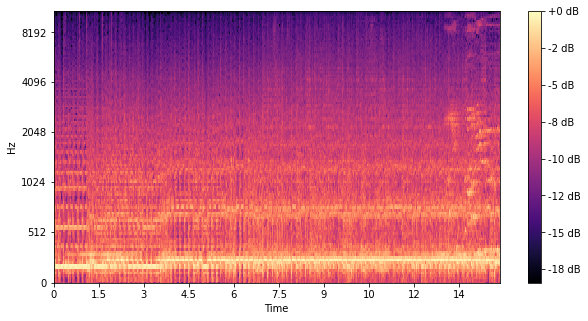

In [7]:
#Build spectogram

#Getting first instance of spectogram array and its corresponding genre
spectogram = X_train[5300]
genre = y_train[5300]

print(genres_dict[np.argmax(genre)])
plt.figure(figsize=(10, 5));
librosa.display.specshow(spectogram.T, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');


Creating CNN-RNN Model

In [8]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

#Model Parameters
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_ratio = 0.001

In [9]:
def build_cnn_rnn_model():
    
    print('Building model...')
    model = Sequential()
    
    #CNN Layer
    # model.add(Embedding(128, num_classes))
    input_shape = (None, 128)
    model.add(keras.Input(shape=input_shape))
    model.add(Conv1D(CONV_FILTER_COUNT, 
                     kernel_size=FILTER_LENGTH, 
                     kernel_regularizer=regularizers.l2(L2_ratio),
                     padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation(keras.activations.relu))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Conv1D(CONV_FILTER_COUNT, 
                     kernel_size=FILTER_LENGTH, 
                     kernel_regularizer=regularizers.l2(L2_ratio),
                     padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation(keras.activations.relu))

    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Conv1D(CONV_FILTER_COUNT, 
                     kernel_size=FILTER_LENGTH, 
                     kernel_regularizer=regularizers.l2(L2_ratio),
                     padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation(keras.activations.relu))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    
    #LSTM (RNN) Layer
    model.add(LSTM(LSTM_COUNT, return_sequences=False))
    model.add(Dropout(0.4))
    
    #Dense Layer
    model.add(Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_ratio), activation='relu'))
    model.add(Dropout(0.4))
    
    #Softmax output for predicting genre categorical probability
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.001), 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model
    
    
    

In [10]:
def train_model(model, X_train, y_train, X_val, y_val):
    
    n_features = X_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    #Save when reaches max val_acc
    checkpoint_callback = ModelCheckpoint("../content/drive/My Drive/crnn/models/best_weights.h5", monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1)
    
    callbacks_list = [checkpoint_callback, reducelr_callback]
    
    #Fit model
    print('Training...')
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                        epochs=EPOCH_COUNT, validation_data=(X_val, y_val), 
                        verbose=1, callbacks=callbacks_list)
    
    return model, history

In [11]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
crnn = build_cnn_rnn_model()

model, history = train_model(crnn, X_train, y_train, X_valid, y_valid)

Building model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 56)          35896     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 56)          224       
_________________________________________________________________
activation (Activation)      (None, None, 56)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 56)          0         
_________________________________________________________________
dropout (Dropout)            (None, None, 56)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 56)          15736     
_________________________________________________________________
batch_normalization_1 (Batch (None, No

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


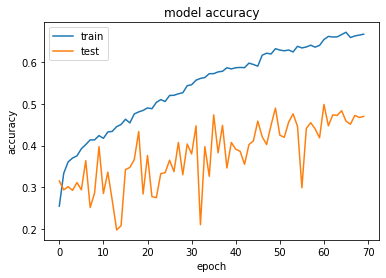

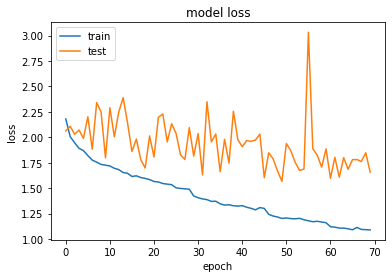

In [13]:
show_summary_stats(history)

In [14]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis=1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)

target_names = genres_dict.values()
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

   Electronic       0.42      0.52      0.46       100
 Experimental       0.36      0.65      0.46       100
         Folk       0.76      0.51      0.61       100
      Hip-Hop       0.66      0.49      0.56       100
 Instrumental       0.38      0.42      0.40       100
International       0.51      0.53      0.52       100
          Pop       0.15      0.10      0.12       100
         Rock       0.76      0.54      0.63       100

     accuracy                           0.47       800
    macro avg       0.50      0.47      0.47       800
 weighted avg       0.50      0.47      0.47       800



In [15]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))



0.47


Testing the model using test dataset

In [7]:
from keras.models import load_model

weight_path = "/content/drive/My Drive/crnn/models/best_weights.h5"
model = load_model(weight_path)

In [35]:
#Load the test data
test_npz = np.load("../content/drive/My Drive/crnn/data/test.npz")
X_test = test_npz['arr_0']
y_test = test_npz['arr_1']
print(X_test.shape, y_test.shape)

(800, 640, 128) (800,)


In [36]:
#Genres are made with zero-index
y_test -= 1

print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [16]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000000000000016 0.004623813018385694


In [29]:
X_test = np.log(X_test_raw)

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
target_names = genres_dict.values()



print(y_test.shape, y_pred.shape)
print(classification_report(y_test, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.82      0.31      0.45       100
 Experimental       0.25      0.33      0.28       100
         Folk       0.10      0.11      0.11       100
      Hip-Hop       0.71      0.80      0.75       100
 Instrumental       0.30      0.25      0.27       100
International       0.42      0.56      0.48       100
          Pop       0.30      0.35      0.33       100
         Rock       0.62      0.50      0.56       100

     accuracy                           0.40       800
    macro avg       0.44      0.40      0.40       800
 weighted avg       0.44      0.40      0.40       800



In [34]:
y_true = keras.utils.to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 11ms/step - loss: 1.9827 - accuracy: 0.4013


[1.9827232360839844, 0.4012500047683716]

In [37]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[31  3 10  9 11 25 10  1]
 [ 3 33  7  6 23 15  7  6]
 [ 0 44 11  0 15  9 19  2]
 [ 0  4  1 80  1  9  5  0]
 [ 1 27 32  3 25  5  3  4]
 [ 1  0 19  4  4 56 13  3]
 [ 2  4 19  9  2 15 35 14]
 [ 0 18  6  1  2  0 23 50]]


In [38]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))


0.40125


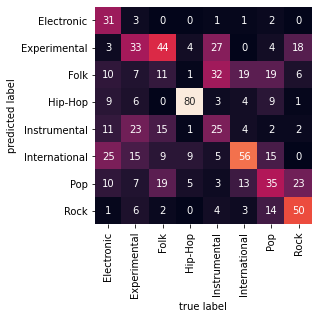

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genres_dict.values(),
            yticklabels=genres_dict.values());
plt.xlabel('true label');
plt.ylabel('predicted label');
